In [ ]:
# Remodelling the work Octopus Energy gave to me.

In [1]:
# Libraries to import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

# ML Library
# ML Preprocessing data
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, TimeSeriesSplit
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# ML Pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


# ML Algorthims and Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

# ML Fine Tune Model
from sklearn.model_selection import GridSearchCV

# ML Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

# Pandas settings
pd.set_option('display.max_columns', None)

## Goal of the project
work out what are good predictors of generation and produce a model to help the traders predict solar output for the following day for one of our farms. 

You’ve been provided with 4 data files to work from:

The half hourly output from the solar farm in kWh – kia_ora.csv

The day ahead hourly weather forecast (resampled to be half hourly) – forecast_data.csv

Theoretical solar radiation for the site – kia-ora-radiation.csv

Day ahead price and imbalance price series – prices.csv

Feel free to use any, all or none of this data or you can pull other data that you think is useful to provide insight around this question. 

## Further explanation
We’d like you to build a model to predict the output of the Kia-Ora site per half hour in kWh. The model should:

Ideally be written in Python (you can use whichever libraries you wish) – other tools can be used if required
Be presented in a Jupyter notebook and/or in slides
Be properly cross validated and tested

You can use whichever features you like and any algorithm.

You can choose whichever model performance metric you think is appropriate to the problem. The trader’s aim is to minimise the cost of being out of balance so the optimisation should take this into account. 

You can choose how you split the dataset for training and testing but this decision should be justifiable.

## Ending
The trading process you should assume for this task is:

- We get the weather forecast for the day ahead
- We run the model to predict production
- We sell that amount of electricity on the day ahead auction at the day ahead price
- We have to buy/sell the difference between what we produced and what we sold at the imbalance price




## The prediction process:
So we skip the first target label and start from second one. i.e. when we pick x-variable day 1 data we will assign a label for y-variable from day 2.

In [2]:
# Importing the data and its features.
## X-variable features
# Weather forecast data
day_ahead_weather_half_hourly_forecast_df = pd.read_csv('case_study/forecast_data.csv')
# Solar radiation that hits the land at that area, not the solar panel.
theoretical_solar_radiation_kia_ora_df = pd.read_csv("case_study/kia-ora-radiation.csv")

## Y-variable labels
half_hourly_output_from_the_solar_farm_in_kWh_df = pd.read_csv('case_study/kia-ora.csv')

## Performance Measure Metric
day_ahead_price_and_imbalance_df = pd.read_csv("case_study/prices.csv",encoding='latin1')

## Preparing the data to be pre-processed

In [3]:
# Changing the units from MWh to kWh as per the question to keep consistency in units.
day_ahead_price_and_imbalance_df['imbalance_price_£/MWh'] = day_ahead_price_and_imbalance_df['imbalance_price_£/MWh'] / 1000
day_ahead_price_and_imbalance_df['day_ahead_£/MWh'] = day_ahead_price_and_imbalance_df['day_ahead_£/MWh'] / 1000
day_ahead_price_and_imbalance_df.rename(columns={"imbalance_price_£/MWh":"imbalance_price_£/kWh", "day_ahead_£/MWh":"day_ahead_£/kWh"}, inplace=True)

In [4]:
day_ahead_price_and_imbalance_df

,utc,imbalance_price_£/kWh,day_ahead_£/kWh
0,30/09/2016 23:00,0.026967,0.03705
1,30/09/2016 23:30,0.026250,0.03705
2,01/10/2016 00:00,0.026359,0.03050
3,01/10/2016 00:30,0.022000,0.03050
4,01/10/2016 01:00,0.022000,0.03154
...,...,...,...
13866,16/08/2017 20:30,0.010000,0.04300
13867,16/08/2017 21:00,0.010000,0.04302
13868,16/08/2017 21:30,0.010000,0.04302
13869,16/08/2017 22:00,0.026160,0.03595


In [5]:
## Shifting the timeUTC by one day ahead to have consistency in the timeline.
# first converting timeUTC string object to a datetime object
day_ahead_weather_half_hourly_forecast_df['timeUTC'] = pd.to_datetime(day_ahead_weather_half_hourly_forecast_df['timeUTC']).dt.tz_localize(None)
# shifting all the dates by 1 day ahead.
day_ahead_weather_half_hourly_forecast_df['timeUTC'] = day_ahead_weather_half_hourly_forecast_df['timeUTC'] + pd.Timedelta("1 days")

In [6]:
same_day_weather_half_hourly_forecast_df = day_ahead_weather_half_hourly_forecast_df.copy()

same_day_weather_half_hourly_forecast_df['timeUTC'][0]
# same_day_weather_half_hourly_forecast_df.loc[(same_day_weather_half_hourly_forecast_df['timeUTC']>=datetime(2016,10,1)) & (same_day_weather_half_hourly_forecast_df['timeUTC']<datetime(2016,10,2))]

Timestamp('2016-09-02 00:00:00')

In [7]:
# converting the timeUTC string object to datetime object.
theoretical_solar_radiation_kia_ora_df['timeUTC'] = pd.to_datetime(theoretical_solar_radiation_kia_ora_df['timeUTC']).dt.tz_localize(None)
# theoretical_solar_radiation_kia_ora_df.loc[theoretical_solar_radiation_kia_ora_df['timeUTC'].str.contains("2016-10-01")]
theoretical_solar_radiation_kia_ora_df['timeUTC'][0]

Timestamp('2016-09-30 00:00:00')

In [8]:
# converting the utc string object to datetime object.
# Also converting from current timezone to a local timezone.
half_hourly_output_from_the_solar_farm_in_kWh_df['utc'] = pd.to_datetime(half_hourly_output_from_the_solar_farm_in_kWh_df['utc'], utc=True).dt.tz_convert(None)
half_hourly_output_from_the_solar_farm_in_kWh_df.rename(columns={'utc':'timeUTC'}, inplace=True)

In [9]:
half_hourly_output_from_the_solar_farm_in_kWh_df['timeUTC'][0]

Timestamp('2016-09-30 23:00:00')

In [10]:
## Merging the data into one x-variable features dataframe.
features_df = pd.merge(same_day_weather_half_hourly_forecast_df, theoretical_solar_radiation_kia_ora_df, how='inner', left_on="timeUTC", right_on="timeUTC")

In [11]:
## Merging into one dataframe with corresponding x-variable features and target labels.
x_y_final_df = pd.merge(features_df, half_hourly_output_from_the_solar_farm_in_kWh_df, how='inner', left_on="timeUTC", right_on="timeUTC")

In [12]:
x_y_final_df[:9284]

,timeUTC,apparentTemperature,cloudCover,dewPoint,humidity,icon,ozone,precipAccumulation,precipIntensity,precipProbability,precipType,pressure,summary,sunriseTime,sunsetTime,temperature,visibility,windBearing,windGust,windSpeed,day_offset,radiation,production_kWh
0,2016-09-30 23:00:00,10.08,0.78,7.93,0.86,partly-cloudy-night,268.50,NaN,0.0,0.0,NaN,1015.62,Mostly Cloudy,2016-09-29 06:12:30,2016-09-29 17:57:40,10.08,16.09,234,NaN,3.38,1,0.000000,0.0
1,2016-10-01 00:00:00,10.48,0.82,8.38,0.87,partly-cloudy-night,274.00,NaN,0.0,0.0,NaN,1014.78,Mostly Cloudy,2016-09-30 06:14:05,2016-09-30 17:55:25,10.48,16.09,212,NaN,2.91,1,0.000000,0.0
2,2016-10-01 00:30:00,10.48,0.82,8.38,0.87,partly-cloudy-night,274.00,NaN,0.0,0.0,NaN,1014.78,Mostly Cloudy,2016-09-30 06:14:05,2016-09-30 17:55:25,10.48,16.09,212,NaN,2.91,1,0.000000,0.0
3,2016-10-01 01:00:00,10.57,0.79,8.57,0.87,partly-cloudy-night,278.14,NaN,0.0,0.0,NaN,1014.41,Mostly Cloudy,2016-09-30 06:14:05,2016-09-30 17:55:25,10.57,16.09,213,NaN,2.88,1,0.000000,0.0
4,2016-10-01 01:30:00,10.57,0.79,8.57,0.87,partly-cloudy-night,278.14,NaN,0.0,0.0,NaN,1014.41,Mostly Cloudy,2016-09-30 06:14:05,2016-09-30 17:55:25,10.57,16.09,213,NaN,2.88,1,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9279,2017-07-13 09:30:00,15.76,0.69,12.03,0.78,partly-cloudy-day,326.96,NaN,0.0,0.0,NaN,1015.97,Mostly Cloudy,2017-07-12 04:15:05,2017-07-12 20:25:37,15.76,16.09,27,6.84,5.11,1,812.907118,392.5
9280,2017-07-13 10:00:00,16.84,0.73,11.98,0.73,partly-cloudy-day,325.76,NaN,0.0,0.0,NaN,1016.97,Mostly Cloudy,2017-07-12 04:15:05,2017-07-12 20:25:37,16.84,16.09,31,5.72,4.64,1,827.677188,520.4
9281,2017-07-13 10:30:00,16.84,0.73,11.98,0.73,partly-cloudy-day,325.76,NaN,0.0,0.0,NaN,1016.97,Mostly Cloudy,2017-07-12 04:15:05,2017-07-12 20:25:37,16.84,16.09,31,5.72,4.64,1,838.756645,526.5
9282,2017-07-13 11:00:00,18.03,0.73,11.97,0.68,partly-cloudy-day,325.58,NaN,0.0,0.0,NaN,1017.84,Mostly Cloudy,2017-07-12 04:15:05,2017-07-12 20:25:37,18.03,16.09,33,4.44,3.97,1,846.714481,458.9


In [13]:
# Searching for correlation features between the x and y variables
corr_matrix = x_y_final_df.corr()

In [14]:
# Features that best correlate with y-variable production_kWh
corr_matrix['production_kWh'].sort_values(ascending=False)

production_kWh         1.000000
radiation              0.754439
temperature            0.420831
apparentTemperature    0.408679
dewPoint               0.296034
visibility             0.151326
windSpeed              0.122255
ozone                  0.081906
windBearing            0.061792
precipIntensity        0.043305
precipProbability      0.035805
pressure              -0.005864
cloudCover            -0.026350
windGust              -0.071977
precipAccumulation    -0.153929
humidity              -0.433149
day_offset                  NaN
Name: production_kWh, dtype: float64

array([[<AxesSubplot:xlabel='production_kWh', ylabel='production_kWh'>,
        <AxesSubplot:xlabel='radiation', ylabel='production_kWh'>,
        <AxesSubplot:xlabel='temperature', ylabel='production_kWh'>,
        <AxesSubplot:xlabel='apparentTemperature', ylabel='production_kWh'>,
        <AxesSubplot:xlabel='dewPoint', ylabel='production_kWh'>,
        <AxesSubplot:xlabel='visibility', ylabel='production_kWh'>],
       [<AxesSubplot:xlabel='production_kWh', ylabel='radiation'>,
        <AxesSubplot:xlabel='radiation', ylabel='radiation'>,
        <AxesSubplot:xlabel='temperature', ylabel='radiation'>,
        <AxesSubplot:xlabel='apparentTemperature', ylabel='radiation'>,
        <AxesSubplot:xlabel='dewPoint', ylabel='radiation'>,
        <AxesSubplot:xlabel='visibility', ylabel='radiation'>],
       [<AxesSubplot:xlabel='production_kWh', ylabel='temperature'>,
        <AxesSubplot:xlabel='radiation', ylabel='temperature'>,
        <AxesSubplot:xlabel='temperature', ylabel='temper

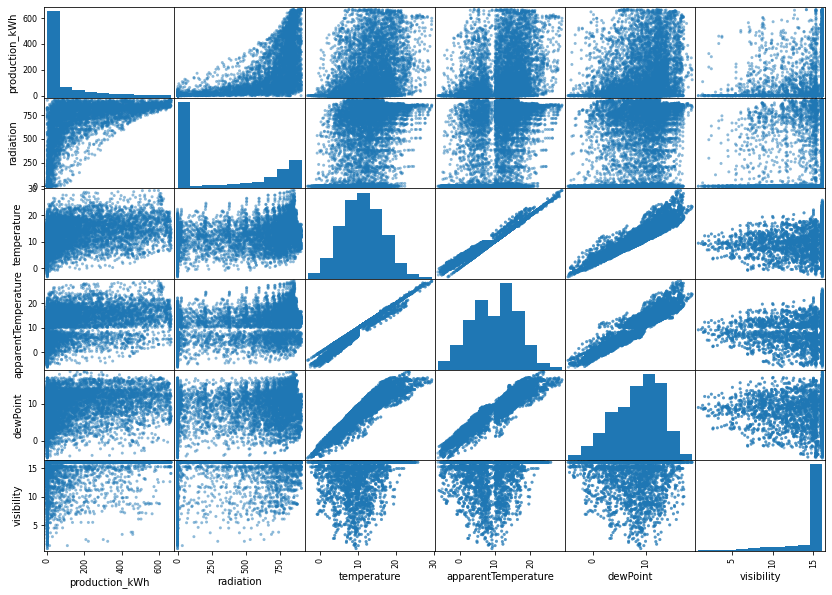

In [15]:
# Plotting the correlation with each parameter and production_kWh on the chart
from pandas.plotting import scatter_matrix

# Selecting the top 5 best correlated features
attributes = ["production_kWh","radiation", "temperature", "apparentTemperature", "dewPoint", "visibility"]
scatter_matrix(x_y_final_df[attributes], figsize=(14, 10))

In [16]:
x_y_df_filtered = x_y_final_df[attributes].copy()
x_y_df_filtered

,production_kWh,radiation,temperature,apparentTemperature,dewPoint,visibility
0,0.0,0.0,10.08,10.08,7.93,16.09
1,0.0,0.0,10.48,10.48,8.38,16.09
2,0.0,0.0,10.48,10.48,8.38,16.09
3,0.0,0.0,10.57,10.57,8.57,16.09
4,0.0,0.0,10.57,10.57,8.57,16.09
...,...,...,...,...,...,...
11136,0.0,0.0,16.18,16.18,13.85,11.07
11137,0.0,0.0,16.29,16.29,14.27,11.86
11138,0.0,0.0,16.29,16.29,14.27,11.86
11139,0.0,0.0,16.54,16.57,14.67,12.65


In [17]:
# Creating a preprocessing data pipeline
# the dataframe will be passed into the pipeline and the below transformers will act on it.

x_attribs = ["radiation", "temperature", "apparentTemperature", "dewPoint", "visibility"]
x_dataframe = x_y_df_filtered[x_attribs]

numeric_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('minmax', MinMaxScaler()),
    ])

prepared_x_df = numeric_pipeline.fit_transform(x_dataframe)

In [18]:
prepared_x_df

array([[0.        , 0.40976059, 0.46301057, 0.54059829, 1.        ],
       [0.        , 0.42203806, 0.47443588, 0.55982906, 1.        ],
       [0.        , 0.42203806, 0.47443588, 0.55982906, 1.        ],
       ...,
       [0.        , 0.60036832, 0.64038846, 0.81153846, 0.72244094],
       [0.        , 0.60804174, 0.64838618, 0.82863248, 0.77427822],
       [0.        , 0.61540823, 0.66095401, 0.88760684, 0.67060367]])

In [19]:
## Splitting the data into Train and Test datasets.
## Due to the fact, this is a Time-Series data sets and hence the value of the next day is dependent on the preceding day value, hence I can't just do a random StratifiedShuffleSplit
X = prepared_x_df.copy()
len(X)

11141

In [20]:
X

array([[0.        , 0.40976059, 0.46301057, 0.54059829, 1.        ],
       [0.        , 0.42203806, 0.47443588, 0.55982906, 1.        ],
       [0.        , 0.42203806, 0.47443588, 0.55982906, 1.        ],
       ...,
       [0.        , 0.60036832, 0.64038846, 0.81153846, 0.72244094],
       [0.        , 0.60804174, 0.64838618, 0.82863248, 0.77427822],
       [0.        , 0.61540823, 0.66095401, 0.88760684, 0.67060367]])

In [21]:
# Target/Label variable
y = x_y_df_filtered[['production_kWh']].values
len(y)

11141

In [22]:
y

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [23]:
# Cross-Validation and Hyper-Parameter tuning. 
# Training the model and getting the score to measure the accuracy.
## Hence I will split the data via TimeSeriesSplit method, as it keeps the importance of seasonality in data and the data NOT independent.

In [24]:
# root-mean squared error metric used.
def cross_val_func(model, X, y):
    rmse_vals = []
    split_obj = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
    for train_index, test_index in split_obj.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model_obj = model
        model_obj.fit(X_train, y_train)
        y_predicted_vals = model_obj.predict(X_test)
        # RMSE
        lin_mse = mean_squared_error(y_test, y_predicted_vals)
        lin_rmse = np.sqrt(lin_mse)    
        rmse_vals.append(lin_rmse)
    return rmse_vals
    
    
    

In [25]:
## Linear Regression model

lin_reg = LinearRegression()
lin_reg_scores = cross_val_func(lin_reg, X, y)

print(f"Root Mean Squared Error: {lin_reg_scores} values for production of electricity in kWh")

Root Mean Squared Error: [79.76111884598808, 110.45894383562224, 138.3759648525917, 129.0828051805553, 110.16543250535729] values for production of electricity in kWh


In [26]:
# Further analysis to see the mean and standard deviation of the scores.
pd.Series(lin_reg_scores).describe()

count      5.000000
mean     113.568853
std       22.473836
min       79.761119
25%      110.165433
50%      110.458944
75%      129.082805
max      138.375965
dtype: float64

In [27]:
## Random Forest Regressor model
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
y_vals_adapated = y.ravel()
forest_reg_scores = cross_val_func(forest_reg, X, y_vals_adapated)

print(f"Root Mean Squared Error: {forest_reg_scores} values for production of electricity in kWh")

Root Mean Squared Error: [80.96158945753766, 122.80822647082134, 130.50649262661113, 117.1807290778542, 117.14223823326098] values for production of electricity in kWh


In [28]:
pd.Series(forest_reg_scores).describe()

count      5.000000
mean     113.719855
std       19.112718
min       80.961589
25%      117.142238
50%      117.180729
75%      122.808226
max      130.506493
dtype: float64

In [130]:
## SVM model
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg_scores = cross_val_func(svm_reg, X, y)

print(f"Root Mean Squared Error: {svm_reg_scores} values for production of electricity in kWh")

/Users/nikitaizmailov/ml/nlp_project/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nikitaizmailov/ml/nlp_project/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nikitaizmailov/ml/nlp_project/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nikitaizmailov/ml/nlp_project/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y 

Root Mean Squared Error: [81.02372386309939, 129.92159763180058, 183.24472016053537, 161.7312687809703, 119.79535717755657] values for production of electricity in kWh


In [131]:
pd.Series(svm_reg_scores).describe()

count      5.000000
mean     135.143334
std       39.409456
min       81.023724
25%      119.795357
50%      129.921598
75%      161.731269
max      183.244720
dtype: float64

In [ ]:
## ## Recurring Neural Network

In [29]:
# Preparing y-variable data by scaling it.
y_minmax_data = numeric_pipeline.fit_transform(y)

In [30]:
# Preparing the data first.
# using rolling window method, where we use previous 20 days to predict value for 21st day
look_back_days = 20

x_data, y_data = [], []
for i in range(look_back_days, len(X)):
    x_data.append(X[i-look_back_days:i])
    y_data.append(y_minmax_data[i])

In [31]:
# making 3 dimensional shape
x_data_formatted = np.array(x_data)

In [32]:
# 3 dimensional shape
x_data_formatted.shape

(11121, 20, 5)

In [33]:
# 2 dimensional
y_data_formatted = np.array(y_data)

In [34]:
# making 3 dimensional
y_data_formatted2 = np.reshape(y_data_formatted, (y_data_formatted.shape[0], 1, y_data_formatted.shape[1]))

In [35]:
# now 3 dimensional shape
y_data_formatted2.shape

(11121, 1, 1)

In [36]:
# train and test dataset splitting
# 80% train and 20% test datasets
train_size = int(len(x_data_formatted) * 0.8)
x_train, x_test = x_data_formatted[0:train_size], x_data_formatted[train_size:]
y_train, y_test = y_data_formatted2[0:train_size], y_data_formatted2[train_size:]

In [37]:
# Building the LSTM Model
lstm = Sequential()
# input shape(time steps, features)
lstm.add(LSTM(4, input_shape=(look_back_days, 5)))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
lstm.fit(x_train, y_train, epochs=20, batch_size=1, verbose=2)

2022-01-18 20:46:32.945178: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
8896/8896 - 20s - loss: 0.0327 - 20s/epoch - 2ms/step
Epoch 2/20
8896/8896 - 20s - loss: 0.0284 - 20s/epoch - 2ms/step
Epoch 3/20
8896/8896 - 20s - loss: 0.0271 - 20s/epoch - 2ms/step
Epoch 4/20
8896/8896 - 20s - loss: 0.0256 - 20s/epoch - 2ms/step
Epoch 5/20
8896/8896 - 20s - loss: 0.0248 - 20s/epoch - 2ms/step
Epoch 6/20
8896/8896 - 31s - loss: 0.0241 - 31s/epoch - 3ms/step
Epoch 7/20
8896/8896 - 23s - loss: 0.0238 - 23s/epoch - 3ms/step
Epoch 8/20
8896/8896 - 24s - loss: 0.0235 - 24s/epoch - 3ms/step
Epoch 9/20
8896/8896 - 25s - loss: 0.0233 - 25s/epoch - 3ms/step
Epoch 10/20
8896/8896 - 26s - loss: 0.0232 - 26s/epoch - 3ms/step
Epoch 11/20
8896/8896 - 20s - loss: 0.0227 - 20s/epoch - 2ms/step
Epoch 12/20
8896/8896 - 20s - loss: 0.0226 - 20s/epoch - 2ms/step
Epoch 13/20
8896/8896 - 20s - loss: 0.0226 - 20s/epoch - 2ms/step
Epoch 14/20
8896/8896 - 20s - loss: 0.0227 - 20s/epoch - 2ms/step
Epoch 15/20
8896/8896 - 20s - loss: 0.0224 - 20s/epoch - 2ms/step
Epoch 16/20
8896/88

In [119]:
# Save the trained model.
import joblib
joblib.dump(lstm, "my_lstm_model.pkl")
# and later...
# my_model_loaded = joblib.load("my_lstm_model.pkl")

INFO:tensorflow:Assets written to: ram://cb00d36f-db45-48f7-888d-b87acd8d5b94/assets


INFO:tensorflow:Assets written to: ram://cb00d36f-db45-48f7-888d-b87acd8d5b94/assets


['my_lstm_model.pkl']

In [123]:
# Making predictions with LSTM model
trainPredict = lstm.predict(x_train)
testPredict = lstm.predict(x_test)

In [124]:
trainPredict

array([[0.5057873 ],
       [0.54866934],
       [0.58620465],
       ...,
       [0.49486428],
       [0.4577156 ],
       [0.4168652 ]], dtype=float32)

In [125]:
# reshaping to 2d array from 3d
y_train_final = np.reshape(y_train, (-1, 1))
y_train_final

array([[0.23543508],
       [0.58094953],
       [0.89276621],
       ...,
       [0.79601617],
       [0.70091358],
       [0.67680096]])

In [126]:
testPredict

array([[ 0.37427717],
       [ 0.32805392],
       [ 0.2801168 ],
       ...,
       [-0.00996682],
       [-0.00749728],
       [-0.01260338]], dtype=float32)

In [127]:
y_test_final = np.reshape(y_test, (-1,1))
y_test_final

array([[0.56162947],
       [0.44301333],
       [0.31615995],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]])

In [128]:
# invert predictions
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(y)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(y_train_final)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(y_test_final)

In [129]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(y_train_final.ravel(), trainPredict.ravel()))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(y_test_final.ravel(), testPredict.ravel()))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 180.63 RMSE
Test Score: 241.57 RMSE


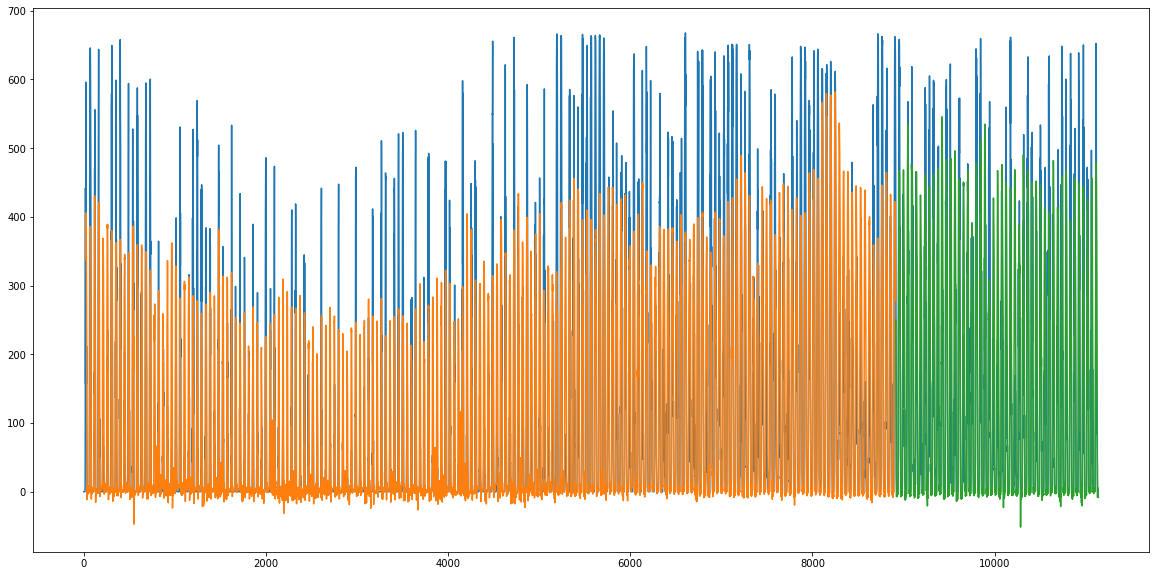

In [116]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(y)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back_days:len(trainPredict) + look_back_days, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(y)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back_days):len(y)] = testPredict

# plot baseline and predictions
plt.plot(y)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.gcf().set_size_inches(20,10)
plt.show()

In [135]:
# Creating a dataframe with Root Mean Squared Error with 4 models
final_error_metric_df = pd.DataFrame({"RMSE mean value": [np.mean(lin_reg_scores), np.mean(forest_reg_scores), np.mean(svm_reg_scores), testScore]}, index=['Linear Regression', 'Forest Regression', 'SVM Regression', 'LSTM Regression'])

In [136]:
# DataFrame with RMSE performance metric for 4 models used
# As we can see Linear Regression is the best model, closely followed by Forest Regression model
final_error_metric_df

,RMSE mean value
Linear Regression,113.568853
Forest Regression,113.719855
SVM Regression,135.143334
LSTM Regression,241.572610


In [139]:
# Linear Regression Model
def predict_vals(model, X, y):
    split_obj = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
    for train_index, test_index in split_obj.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model_obj = model
        model_obj.fit(X_train, y_train)
        y_predicted_vals = model_obj.predict(X_test)
        # RMSE
    return y_test, y_predicted_vals

lin_reg_predict_y_vals = predict_vals(lin_reg, X, y)

In [140]:
y_test_lin_reg = lin_reg_predict_y_vals[0]
y_predicted_lin_reg = lin_reg_predict_y_vals[1]

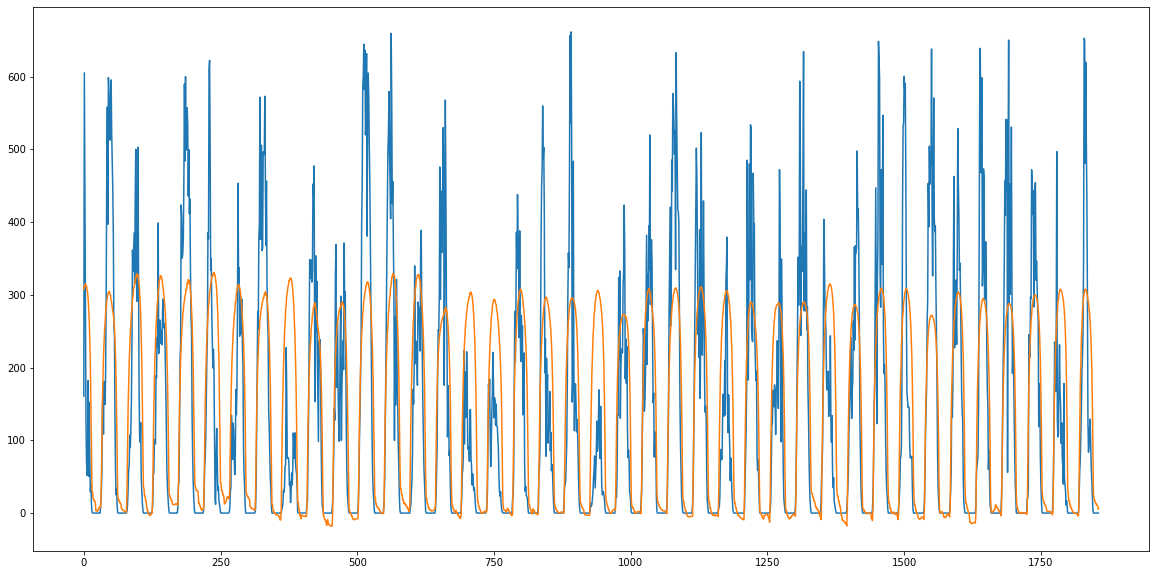

In [141]:
## Plotting the Linear Regression predicted data and the test data for y-variable.
# plot baseline and predictions
plt.plot(y_test_lin_reg)
plt.plot(y_predicted_lin_reg)
plt.gcf().set_size_inches(20,10)
plt.show()